In [1]:
# IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
colors = sns.color_palette('colorblind')

In [2]:
import gym
from gym import spaces
import numpy as np
from Stochastic.src.environment.tree import Tree

class NestedBanditEnv(gym.Env):
    """
    Nested Bandit environment where each arm is a full path from root to leaf in a tree.
    The reward is the sum of sampled node values along the path.
    """

    def __init__(self, seed=None):
        super(NestedBanditEnv, self).__init__()
        self.tree = self.generate_tree()
        means = [self.tree.get_mu_leaf(leaf) for leaf in self.tree.get_all_leaves()]
        self.DELTA = np.array([max(means) - mean for mean in means])
        self.rng = np.random.default_rng(seed)

        self.tree.step()  # initial sampling
        self.leaves = self.tree.get_all_leaves()
        self.K = len(self.leaves)
        self.best_arm = np.argmax([value[2] for value in self.tree.get_mu_leaves()])

        self.action_space = spaces.Discrete(self.K)
        self.observation_space = spaces.Discrete(1)  # stateless

        self.reset()

    def generate_tree(self):
        tree = Tree() 
        root = tree.insert(parent_node=None, name="Targeting", mean=0, var=0)

        # First Layer
        families, _ = tree.insert(parent_node=root, name="families", mean=0.35, var=0.1)
        professionals, _ = tree.insert(parent_node=root, name="professionals", mean=0.45, var=0.1)

        # Second Layer
        adults, _ = tree.insert(parent_node=families, name="adults", mean=0.05, var=0.1)
        youngs, _ = tree.insert(parent_node=families, name="youngs", mean=0.08, var=0.1)

        start_up, _ = tree.insert(parent_node=professionals, name="start-up", mean=0.07, var=0.1)
        companies, _ = tree.insert(parent_node=professionals, name="companies", mean=0.15, var=0.1)

        # Third Layer
        radio, _ = tree.insert(parent_node=adults, name="radio", mean=0.03, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="tv", mean=0.02, var=0.1)
        magazines, _ = tree.insert(parent_node=adults, name="magazines", mean=0.01, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="supermarket", mean=0.03, var=0.1)

        youtube, _ = tree.insert(parent_node=youngs, name="youtube", mean=0.01, var=0.1)
        social_networks, _ = tree.insert(parent_node=youngs, name="social networks", mean=0.02, var=0.1)

        webinaire, _ = tree.insert(parent_node=start_up, name="webinaire", mean=0.03, var=0.1)
        events, _ = tree.insert(parent_node=start_up, name="events", mean=0.05, var=0.1)

        linkedin, _ = tree.insert(parent_node=companies, name="linkedin", mean=0.05, var=0.1)
        email, _ = tree.insert(parent_node=companies, name="email", mean=0.025, var=0.1)

        tree.step()
        return tree

    def reset(self):
        self.t = 0
        self.tree.step()  

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action index"
        self.t += 1

        selected_leaf = self.leaves[action]
        reward = self.tree.get_reward_leaf(selected_leaf)
        expected_reward = self.tree.get_mu_leaf(selected_leaf)

        best_arm_path = self.tree.find_best_arm_path()
        best_expected_reward = np.sum([node.mean for node in best_arm_path])
        best_leaf = best_arm_path[-1].name

        done = False
        info = {
            "step": self.t,
            "selected_leaf": selected_leaf.name,
            "expected_reward": expected_reward,
            "optimal": best_leaf,
            "path": best_arm_path,
            "best_expected_reward": best_expected_reward
        }
        self.tree.step()
        return 0, reward, done, info

    def render(self, mode="human"):
        self.tree.visualize_tree_mu()


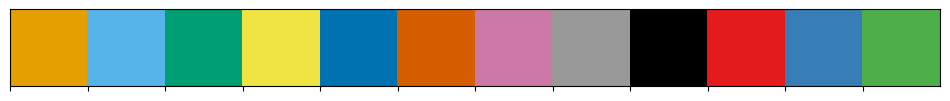

In [3]:
import seaborn as sns 
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
#colors = sns.color_palette('tab10', 14)
colors = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]
sns.palplot(colors)
colors = sns.color_palette("hls", 12)

def experiment(environment, agents, Nmc, T):
    all_data = {}
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)
        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    for episode in tqdm(range(Nmc)):
        environment.reset()
        agent.reset()   
        
        for t in range(T):
            if agent.nested():
                index_action = agent.draw_action(environment.tree)
            else:
                if agent.name()=="Exp3++":
                    index_action = agent.draw_action(gaps=environment.DELTA)
                else:
                    index_action = agent.draw_action()
            _, r, _, info = environment.step(index_action)
            agent.observe_reward(r)

            # Compute pseudo-regret: 
            data[episode, t] = info["best_expected_reward"] - info["expected_reward"] 
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None, horizon=5_000):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="stochastic bound")

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()



def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None, horizon=5_000):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    
    regrets : dict {'agent_name': np.array of regret}
    agents  : list of agent instances, each must have .action_history (flat list of actions played)
    """

    fig, axes = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        ax_regret.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        ax_regret.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="bound")

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time steps")
    ax_regret.legend()
    ax_regret.set_title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")

    # --- Histogram plot ---
    width = 0.8 / len(agents)  # Adjust width for overlap

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue  # Skip if no action data

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents)/2) * width + width/2
        ax_hist.bar(x, freqs, width=width, color=colors[i], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best arm = {env.best_arm})")
    ax_hist.legend()

    plt.tight_layout()
    if save_pdf:
        plt.savefig(save_pdf)
    plt.show()

In [4]:
def get_plot_styles():
    colors = plt.get_cmap("tab10").colors  
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'H', '<']
    return colors, markers


def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None, horizon=5_000):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    """
    colors, markers = get_plot_styles()
    fig, axes = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret Plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100 - q, axis=0)

        ax_regret.plot(
            np.arange(T),
            mean_reg,
            label=agent_id,
            color=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            markevery=int(T / 20),
            linewidth=2
        )
        ax_regret.fill_between(
            np.arange(T),
            q_reg,
            Q_reg,
            color=colors[i % len(colors)],
            alpha=0.2
        )

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T / 10), label="Bound")

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time Steps")
    ax_regret.set_title(f"Cumulative Regret per Agent (T = {horizon})")
    ax_regret.legend()
    ax_regret.grid(True, linestyle='--', alpha=0.5)

    # --- Histogram Plot ---
    width = 0.8 / len(agents)

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents) / 2) * width + width / 2
        ax_hist.bar(x, freqs, width=width, color=colors[i % len(colors)], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best Arm = {env.best_arm})")
    ax_hist.legend()
    ax_hist.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    if save_pdf is not None:
        plt.savefig(save_pdf)
    plt.show()

In [18]:
class Exp3:
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T      
        self.reset()     

    def reset(self):
        self.total_reward = 0
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.R = np.zeros(self.K)
        self.t = 0
        #self.eta = np.sqrt(2*np.log(self.K)/self.T*self.K)
        self.eta = 1 / self.K
        self.action_history = []

    def draw_action(self):
        self.t += 1
        self.eta = min(1//self.K, np.sqrt(np.log(self.K)/self.K*self.t))
        I_t = np.random.choice(range(self.K), p=self.p)
        self.index_action_chosen = I_t
        self.action_history.append(I_t)
        return I_t

    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.p[self.index_action_chosen]
        num = np.exp(-self.eta*self.R)
        self.p = num / np.sum(num)


    def name(self):
        return 'Exp3'
    
    def nested(self):
        return False


In [17]:
class UCB:
  def __init__(self, tree, T):
        self.tree = tree
        self.T = T
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.reset()     

  def reset(self, seed=None):
      self.rng = np.random.default_rng(seed)
      self.total_reward = 0
      self.t = 0  
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.action_history = []
  
  def draw_action(self):
    if self.t < self.K:
        action = self.t % self.K
    else:
        with np.errstate(divide='ignore', invalid='ignore'):
                empirical_means = np.divide(self.count_rewards, self.count_actions, out=np.zeros_like(self.count_rewards), where=self.count_actions != 0)
                ucbs = np.sqrt(2 * np.log(self.t) / self.count_actions)
                scores = empirical_means + ucbs
                action = np.argmax(scores)

    self.t += 1
    self.count_actions[action] += 1
    self.chosen_action = action
    self.action_history.append(action)
    return action

  def observe_reward(self, reward):
    self.total_reward += reward
    self.count_rewards[self.chosen_action] += reward

  def name(self):
    return 'UCB' 
  
  def nested(self):
      return False

In [6]:
class KLUCB():
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.c = 3
        self.T = T
        self.reset()     

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.total_reward = 0
        self.t = 0  
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.action_history = []

    @staticmethod
    def kl_divergence(p, q):
        eps = 1e-12  # avoid log(0)
        p = np.clip(p, eps, 1 - eps)
        q = np.clip(q, eps, 1 - eps)
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
    
    def find_upper_confidence_bound(self, ratio, N_a, t, tol=1e-6):
        """ higher q s.t N_a * d(p, q) <= log(t) + c * log(log(t)) """
        bound = np.log(t) + self.c * np.log(np.log(max(t, 2)))  # avoid log(0)
        low = ratio
        high = 1.0
        while high - low > tol:
            mid = (low + high) / 2
            if N_a * self.kl_divergence(ratio, mid) <= bound:
                low = mid
            else:
                high = mid
        return low    
    
    def draw_action(self):
        if self.t < self.K:
            chosen_action = self.t 
            self.t += 1
        else:
            t = self.t
            quantities = []
            for a in range(self.K):
                ratio_a = self.count_rewards[a] / np.maximum(self.count_actions[a], 1e-8)
                quantities.append(self.find_upper_confidence_bound(ratio_a, self.count_actions[a], self.t))
            chosen_action = np.argmax(quantities)
            self.t += 1

        self.count_actions[chosen_action] += 1
        self.action_history.append(chosen_action)
        self.chosen_action = chosen_action
        return chosen_action


    def observe_reward(self, reward):
        self.total_reward += reward
        self.count_rewards[self.chosen_action] += reward

    def name(self):
        return 'KL-UCB' 
    
    def nested(self):
        return False

In [7]:
class TS:
    def __init__(self, tree, T):
        self.tree = tree
        self.T = T
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.reset()     

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.total_reward = 0
        self.t = 0  
        self.S = np.zeros(self.K)
        self.F = np.zeros(self.K)
        self.action_history = []
   
    
    def draw_action(self):
        self.t += 1
        thetas = np.zeros(self.K)
        for a in self.action_set:
            thetas[a] = np.random.beta(a=self.S[a]+1, b=self.F[a]+ 1)
        chosen_arm = np.argmax(thetas)
        self.chosen_arm = chosen_arm
        self.action_history.append(chosen_arm)
        return chosen_arm


    def observe_reward(self, reward):
        self.total_reward += reward
        r_tilde = reward
        r_t = np.random.binomial(n=1, p=r_tilde)
        if r_t==1:
            self.S[self.chosen_arm] += 1
        else:
            self.F[self.chosen_arm] += 1

    def name(self):
        return 'Thompson Sampling' 
    
    def nested(self):
        return False

In [8]:
class Exp3P:
    """ http://sbubeck.com/SurveyBCB12.pdf """
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T  
        self.delta = 0.05 
        self.beta = np.sqrt(np.log(self.K / self.delta)/self.T * self.K) 
        self.eta = 0.95 * np.sqrt(np.log(self.K)/self.T*self.K)
        self.gamma = 1.05*np.sqrt(self.K*np.log(self.K)/self.T)   
        self.reset()     

    def reset(self):
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.G = np.zeros(self.K)
        self.t = 0
        self.action_history = []

    def draw_action(self):
        I_t = np.random.choice(range(self.K), p=self.p)
        self.index_action_chosen = I_t
        self.action_history.append(I_t)
        self.t += 1
        return I_t

    def observe_reward(self, g):
        estimated_gain = (g + self.beta)/self.p[self.index_action_chosen]
        self.G[self.index_action_chosen] += estimated_gain
        self.p = (1-self.gamma)*(np.exp(self.eta*self.G)/np.sum(np.exp(self.eta*self.G))) + self.gamma/self.K

    def name(self):
        return 'Exp3.P'
    
    def nested(self):
        return False

In [9]:
from math import exp, log

class Exp3ELM():
    """ EXP3 in stochastic settings with arm elimination 
    https://proceedings.mlr.press/v24/seldin12a/seldin12a.pdf """
    def __init__(self, tree, T, delta=.1):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T  
        self.delta = delta
        self.reset()

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.eps = 1 / self.K
        self.action_set = np.arange(self.K)
        self.B = 4 * (exp(1) - 2) * (2 * log(self.K) + log(2/self.delta))
        self.R = np.zeros(self.K)
        self.V = self.K * np.ones(self.K)
        self.w = np.ones(self.K) / self.K
        self.t = 0
        self.action_history = []

    def draw_action(self):
        self.t += 1
        t = self.t
        K = self.K
        card_A = len(self.action_set)
        eps_t = min(1 / K, np.sqrt(np.log(K) / (K * t)))
        num = np.exp(- self.eps * self.R)
        self.w = (1 - card_A * eps_t) * (num / np.sum(num)) + eps_t
        action = self.rng.choice(self.action_set, p=self.w)
        self.index_action_chosen = list(self.action_set).index(action)
        self.eps = eps_t
        self.action_history.append(action)
        return action

    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.w[self.index_action_chosen]
        self.V += 1 / self.w
        self.update_action_set()

    def update_action_set(self):
        a_max = np.argmax(self.R)
        R_max = np.max(self.R)
        lower_bounds = [np.sqrt(
                            self.B * (self.V[a_max] + self.V[i])) for i, a in enumerate(self.action_set)]
        action_set = []
        indices = []
        for i, lb in enumerate(lower_bounds):
            if R_max - self.R[i] <= lb:
                action_set.append(self.action_set[i])
                indices.append(i)
        self.action_set = np.array(action_set)
        self.w = self.w[indices]
        self.w /= np.sum(self.w) 
        self.R = self.R[indices]
        self.V = self.V[indices]

    def name(self):
        return "Exp3ELM"
    
    def nested(self):
        return False

In [10]:
class Exp3PP:
    """ http://proceedings.mlr.press/v32/seldinb14.pdf """
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T   
        self.reset()    
        self.stochastic = True

    def reset(self):
        self.L = np.zeros(self.K)
        self.t = 0
        self.action_history = []

    def draw_action(self, gaps):
        self.t += 1
        beta_t = np.sqrt(np.log(self.K)/self.t*self.K)/2
        if self.stochastic:
            c = 18
            #xi = np.array([np.exp((c * np.log(self.t*gaps[a]**2))/(self.t*gaps[a]**2)) for a in range(self.K)])
            delta_hat2 = [min(1, (self.L[a] - min(self.L))/self.t)**2 for a in range(self.K)]
            xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
            eta_t = beta_t
        else:
            pass
        
        eps = np.array([max(0, min([1/2*self.K, beta_t, xi[a]])) for a in range(self.K)])
        rho = np.exp(-eta_t*self.L)/np.sum(np.exp(-eta_t*self.L))
        rho_t = (1-np.sum(eps))*rho + eps
        rho_tilde = np.exp(rho_t) / np.sum(np.exp(rho_t))
        I_t = np.random.choice(range(self.K), p=rho_tilde)
        self.index_action_chosen = I_t
        self.action_history.append(I_t)
        self.p = rho_tilde
        return I_t

    def observe_reward(self, g):
        estimated_gain = g/self.p[self.index_action_chosen]
        self.L[self.index_action_chosen] += estimated_gain

    def name(self):
        return 'Exp3++'
    
    def nested(self):
        return False

In [11]:
import numpy as np

class NestedExponentialWeights:
    def __init__(self, tree, T, rng_seed=None):
        self.tree = tree
        self.leaves_set = self.tree.get_all_leaves()
        self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
        self.leaves_name = [n.name for n in self.leaves_set]
        self.K = len(self.leaves_set)
        self.rng = np.random.default_rng(rng_seed)
        self.EPS = 1e-8
        self.T = T
        self.all_nodes = self.tree.get_all_nodes()
        self.nb_nodes = len(self.all_nodes)
        self.dic_name_i = {node.name:i for i,node in enumerate(self.all_nodes)}
        self.dic_i_name = {i:node.name for i,node in enumerate(self.all_nodes)}
        self.reset()

    def reset(self):
        self.t = 0
        self.action_history = []
        self.rewards = []
        self.Y = np.zeros(self.nb_nodes)

    def vector_proba(self, y):
        stable_exp_y = np.exp(y - np.max(y))
        sum_exp = np.sum(stable_exp_y)
        if not np.isfinite(sum_exp) or sum_exp == 0:
            # Sécurité : retourne une distribution uniforme
            return np.ones_like(stable_exp_y) / len(stable_exp_y)
        return stable_exp_y / sum_exp

    def draw_action(self, tree_step):
        self.t += 1
        tree = tree_step 
        self.backward()
        self.r = np.zeros(self.nb_nodes)

        node = tree.root 
        index = []
        node_path = []
        proba_path = []
        reward_path = []
        while bool(node.children):
            lr = 1 / np.sqrt(self.t + 1)
            childrens = node.children
            idxs = [self.dic_name_i[n.name] for n in childrens]
            Y = self.Y[idxs]
            proba = self.vector_proba(Y * lr)
            idx_node = self.rng.choice(range(len(childrens)), p=proba)
            chosen_children = childrens[idx_node]
            index.append(self.dic_name_i[chosen_children.name])
            node_path.append(idx_node)
            proba_path.append(Y[idx_node])
            intermediate_reward = chosen_children.value
            reward_path.append(intermediate_reward)
            node = chosen_children
        self.update(tree_step, index, node_path, proba_path, reward_path)
        idx_leaf = self.dico_leaf_i[node.name]
        self.action_history.append(idx_leaf)
        return idx_leaf
    
    def update(self, tree_step, index, node_path, proba_path, reward_path):
        node = tree_step.root  
        proba = 1 
        for i, j, p, r in zip(index, node_path, proba_path, reward_path):
            proba *= p
            self.Y[i] += r / (proba + self.EPS)
            node = node.children[j]

    def backward(self):
        visited = set()
        def _recursive_update(node):
            if node in visited:
                return
            visited.add(node)
            children = node.children
            if not children:
                return 
            children_indices = [self.dic_name_i[child.name] for child in children]
            Y = [self.Y[idx] for idx in children_indices]
            Y = self.vector_proba(Y)
            sum_children = np.log(np.sum(Y))
            self.Y[self.dic_name_i[node.name]] = sum_children
            if node.parent:
                _recursive_update(node.parent)
        for leaf in self.leaves_set:
            if leaf.parent:
                _recursive_update(leaf.parent)

    def observe_reward(self, r):
        self.rewards.append(r)

    def name(self):
        return "NEW"
    
    def nested(self):
        return True

In [12]:
import scipy.optimize as opt

class TsallisInf:
  def __init__(self, tree, T):
    self.tree = tree
    self.action_set = self.tree.get_all_leaves()
    self.K = len(self.action_set)              
    self.EPS = 1e-8   
    self.T = T    
    self.alpha = .5
    self.eps = 1
    self.inverse_exponent = 1.0 / (self.alpha - 1.0)
    self.reset()   

  def PSI_t(self, w):
    return - np.sum(
                    [
                    (w[i]**self.alpha - self.alpha*w[i]) /
                    (self.alpha*(1-self.alpha)*self.eps) 
                    for i in range(self.K)
                    ]
                    )  / self.eta_t

  def reset(self, seed=None):
    self.rng = np.random.default_rng(seed) 
    self.total_loss = 0
    self.t = 0  
    self.eta_t = 2
    self.L_hat = np.zeros(self.K)
    self.weights = np.full(self.K, 1. / self.K)
    self.x = 1 / 2 * self.K
    self.action_history = []

  def draw_action(self):
    self.t += 1
    self.eta_t = 2 / np.sqrt(max(1, self.t))
    action = np.random.choice(self.K, p=self.weights)
    self.index_chosen_action = action
    self.action_history.append(action)
    return action

  def observe_reward(self, reward):
    biased_loss = 1.0 - reward 
    unbiased_loss = biased_loss / self.weights[self.index_chosen_action]  # RV
    self.L_hat[self.index_chosen_action] += unbiased_loss  #update loss

    def objective_function(x):
      return (np.sum( (self.eta_t * (self.L_hat - x)) ** self.inverse_exponent ) - 1) ** 2

    result_of_minimization = opt.minimize_scalar(objective_function)
    x = result_of_minimization.x
    new_weights = (self.eta_t * (self.L_hat - x)) ** self.inverse_exponent
    if not np.all(np.isfinite(new_weights)):
        new_weights[~np.isfinite(new_weights)] = 0  
    if np.isclose(np.sum(new_weights), 0):
        new_weights[:] = 1.0

    new_weights /= np.sum(new_weights)
    self.weights =  new_weights
    return unbiased_loss

  def nested(self):
    return False

  def name(self):
    return 'TsallisInf' 

In [13]:
class SAO:
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T    
        self.delta = 0.05 
        self.beta = (10 / self.delta) * self.K * self.T**3
        self.beta_exp3 = np.sqrt(np.log(self.K / self.delta)/self.T * self.K) 
        self.eta = 0.95 * np.sqrt(np.log(self.K)/self.T*self.K)
        self.gamma = 1.05*np.sqrt(self.K*np.log(self.K)/self.T) 
        self.reset()     

    def reset(self):
        self.A = np.arange(self.K)
        self.A_bar = []
        self.total_reward = 0
        self.p = np.full(self.K, 1.0 / self.K)   
        self.G_tilde = np.zeros(self.K)                     #estimated cumulative reward
        self.G_hat = np.zeros(self.K)                       #algorithm’s cumulative reward
        self.tau = self.T * np.ones(self.K)
        self.q = np.full(self.K, 1.0 / self.K)
        self.count_actions = np.zeros(self.K)
        self.exp3p = False
        self.t = 0
        self.action_history = []


    def draw_action(self):
        #WARM-UP
        if self.t < self.K:
            I_t = self.t 
        else:
            I_t = np.random.choice(self.A, p=self.p)

        self.index_action_chosen = np.where(self.A == I_t)
        self.action_history.append(I_t)
        self.count_actions[self.index_action_chosen] += 1
        self.t += 1
        return I_t
    

    def observe_reward(self, r):
        self.total_reward += r
        self.G_tilde[self.index_action_chosen] += r / self.p[self.index_action_chosen]
        self.G_hat[self.index_action_chosen] += r
        if self.t >= self.K:
            if self.exp3p==False:
                self.check_desactivation() 
                self.update_probas()
            else:
                estimated_gain = (r + self.beta_exp3)/self.p[self.index_action_chosen]
                self.G[self.index_action_chosen] += estimated_gain
                self.p = (1-self.gamma)*(np.exp(self.eta*self.G)/np.sum(np.exp(self.eta*self.G))) + self.gamma/self.K
                

    def check_desactivation(self): #check if arm i should be desactivated
        H_tilde = self.G_tilde / self.t
        lower_bound = 6 * np.sqrt((4 * self.K * np.log(self.beta))/self.t + 5 * (self.K * np.log(self.beta)) / self.t)
        for i_active in self.A:
            #print(max(H_tilde) - H_tilde[i_active], lower_bound)
            if max(H_tilde) - H_tilde[i_active] > lower_bound:
                print(f"Arm {i_active} has been desactivated")
                self.A = self.A[self.A != i_active]
                self.K_active = len(self.A)
                self.A_bar.append(i_active)
                self.q[i_active] = self.p[i_active]
                self.p = np.delete(self.p, i_active)
                self.tau[i_active] = self.t 

            if self.check_h1(i_active) or self.check_h2(i_active) or self.check_h3(i_active):
                print("Exp3.P begin at time t=", self.t)
                self.K_active = len(self.A)
                #print("Length of action set:", self.K_active)
                self.G = np.zeros(self.K_active)
                self.exp3p = True

    def check_h1(self, i):
        t_star = min(self.tau[i], self.t)
        lower_bound = np.sqrt((2 * np.log(self.beta))/(self.count_actions[i])) + np.sqrt(4*((self.K * t_star)/self.t**2) + (self.t - t_star)/(self.q[i]*self.tau[i]*self.t)*np.log(self.beta) + 5*(self.K*np.log(self.beta)/t_star)**2)
        H_tilde_i = self.G_tilde[i] / self.t
        H_hat_i = self.G_hat[i] / self.t
        if np.abs(H_tilde_i - H_hat_i) > lower_bound:
            return True
        else:
            return False 

    def check_h2(self, i):
        if i in self.A:
            return False
        else:
            lower_bound = 10 * np.sqrt((4 * self.K * np.log(self.beta))/(self.tau[i]-1) + 5 * ((self.K * np.log(self.beta))/self.tau[i]-1)**2)
            H_tilde = self.G_tilde / self.t
            if max(H_tilde) - H_tilde[i] > lower_bound:
                return True
            else:
                return False


    def check_h3(self, i):
        if i in self.A:
            return False
        else:
            upper_bound = 2 * np.sqrt((4 * self.K * np.log(self.beta))/(self.tau[i]) + 5 * ((self.K * np.log(self.beta))/self.tau[i])**2)
            H_tilde = self.G_tilde / self.t
            if max(H_tilde) - H_tilde[i] <= upper_bound:
                return True
            else:
                return False

    def update_probas(self):
        for i in range(self.K):
            if i in self.A:
                card = len(self.A)
                self.p[i] = (1 - np.sum([(self.q[j] * self.tau[j])/(self.t + 1) for j in self.A_bar])) / card
            else:
                self.p[i] = (self.q[i] * self.tau[i]) / (self.t + 1)

    def name(self):
        return 'SAO'
    
    def nested(self):
        return False

In [14]:
class NUCB:
  def __init__(self, tree, T):
    self.tree = tree
    self.T = T
    self.tree_structure = self.tree.extract_tree_structure_from_tree()
    self.L = len(self.tree_structure)
    leaves = self.tree.get_all_leaves()
    self.paths = [self.tree.get_parent_nodes(leaf) for leaf in leaves]
    self.len_paths = len(self.paths)
    self.all_nodes = tree.get_all_nodes()
    self.leaves_set = self.tree.get_all_leaves()
    self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
    self.leaves_name = [n.name for n in self.leaves_set]
    self.K = len(self.leaves_set)
    self.reset()     

  def reset(self, seed=None):
    self.rng = np.random.default_rng(seed) 
    self.total_reward = 0
    self.t = 0  
    self.counts = {node.name: float(0) for node in self.all_nodes}
    self.rewards = {node.name: float(0) for node in self.all_nodes}
    self.t = 0
    self.action_history = []
  
  def draw_action(self, tree_step):
    current_node = tree_step.extract_tree_structure_from_tree()[0][0]
    #current_node = self.tree_structure[0][0]  # root
    path = [current_node]

    if self.t < self.len_paths:  # Exploration phase
        path = self.paths[self.t % self.len_paths]
    else:
        #for _ in self.tree_structure[1:]:
        for _ in tree_step.extract_tree_structure_from_tree()[1:]:
            parent_node = path[-1]
            children = parent_node.children  # Only consider children of the last chosen node

            # Filter out children with 0 visits to avoid division by zero
            count_rewards = np.array([self.rewards[child.name] for child in children])
            count_actions = np.array([self.counts[child.name] for child in children])

            # Avoid division by zero in empirical means
            empirical_means = np.zeros_like(count_rewards)
            mask = count_actions > 0
            empirical_means[mask] = count_rewards[mask] / count_actions[mask]

            # UCB term: infinite if not yet visited
            ucbs = np.sqrt(2 * np.log(self.t) / np.maximum(count_actions, 1e-6))
            ucbs[~mask] = float('inf')  # Ensure unvisited nodes are explored

            scores = empirical_means + ucbs
            best_child_idx = np.argmax(scores)
            node_action = children[best_child_idx]

            path.append(node_action)
            self.counts[node_action.name] += 1

    self.t += 1
    self.path_node = path
    self.path_reward = [node.value for node in path]
    index_action = self.dico_leaf_i[path[-1].name]
    self.action_history.append(index_action)
    #return path
    return index_action

  def observe_reward(self, reward):
    self.total_reward += reward
    for node, reward in zip(self.path_node, self.path_reward):
      self.rewards[node.name] += reward
      self.counts[node.name] += 1

  def nested(self):
    return True

  def name(self):
    return 'NUCB' 

In [15]:
class NKLUCB:
    def __init__(self, tree, T):
        self.tree = tree
        self.T = T
        self.tree_structure = self.tree.extract_tree_structure_from_tree()
        self.L = len(self.tree_structure)
        leaves = self.tree.get_all_leaves()
        self.paths = [self.tree.get_parent_nodes(leaf) for leaf in leaves]
        self.len_paths = len(self.paths)
        self.all_nodes = tree.get_all_nodes()
        self.leaves_set = self.tree.get_all_leaves()
        self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
        self.leaves_name = [n.name for n in self.leaves_set]
        self.K = len(self.leaves_set)
        self.c = 18
        self.reset()     

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed) 
        self.total_reward = 0
        self.t = 0  
        self.counts = {node.name: float(0) for node in self.all_nodes}
        self.rewards = {node.name: float(0) for node in self.all_nodes}
        self.t = 0
        self.action_history = []

    @staticmethod
    def kl_divergence(p, q):
        eps = 1e-12  # avoid log(0)
        p = np.clip(p, eps, 1 - eps)
        q = np.clip(q, eps, 1 - eps)
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
    
    def find_upper_confidence_bound(self, ratio, N_a, t, tol=1e-6):
        """ higher q s.t N_a * d(p, q) <= log(t) + c * log(log(t)) """
        bound = np.log(t) + self.c * np.log(np.log(max(t, 2)))  # avoid log(0)
        low = ratio
        high = 1.0
        while high - low > tol:
            mid = (low + high) / 2
            if N_a * self.kl_divergence(ratio, mid) <= bound:
                low = mid
            else:
                high = mid
        return low    
  

    def draw_action(self, tree_step):
        current_node = tree_step.extract_tree_structure_from_tree()[0][0]
        path = [current_node]

        if self.t < self.len_paths:  # Exploration phase
            path = self.paths[self.t % self.len_paths]
        else:
            #for _ in self.tree_structure[1:]:
            for _ in tree_step.extract_tree_structure_from_tree()[1:]:
                parent_node = path[-1]
                children = parent_node.children  # Only consider children of the last chosen node

                # Filter out children with 0 visits to avoid division by zero
                count_rewards = np.array([self.rewards[child.name] for child in children])
                count_actions = np.array([self.counts[child.name] for child in children])

                ratio = count_rewards / count_actions
                quantities = np.array([self.find_upper_confidence_bound(ratio[child], self.counts[children[child].name], self.t) for child in range(len(count_rewards))])

                chosen_action = np.argmax(quantities)
                node_action = children[chosen_action]

                path.append(node_action)
                self.counts[node_action.name] += 1

        self.t += 1
        self.path_node = path
        self.path_reward = [node.value for node in path]
        index_action = self.dico_leaf_i[path[-1].name]
        self.action_history.append(index_action)
        #return path
        return index_action

    def observe_reward(self, reward):
        self.total_reward += reward
        for node, reward in zip(self.path_node, self.path_reward):
            self.rewards[node.name] += reward
            self.counts[node.name] += 1

    def name(self):
        return 'Nested KL-UCB' 
    
    def nested(self):
        return True

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Score for each child
        )

    def forward(self, x):
        return self.fc(x).squeeze(-1)  # (batch_size,) output of scores


class NN():
    def __init__(self, tree, T, input_dim=4, hidden_dim=10, lr=1e-3, seed=None):
        self.tree = tree
        self.T = T
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.rng = np.random.default_rng(seed)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.policy_net = PolicyNetwork(input_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Assumes each node has a method .features returning a numpy array of size input_dim
        self.reset()

    def reset(self):
        self.t = 0
        self.log_probs = []
        self.rewards = []
        self.action_history = []

    def draw_action(self, tree_step):
        self.t += 1
        node = tree_step.root
        log_probs = []
        path = []

        while node.children:
            children = node.children
            child_feats = torch.tensor([child.features() for child in children], dtype=torch.float32).to(self.device)
            scores = self.policy_net(child_feats)
            probs = torch.softmax(scores, dim=0)

            m = torch.distributions.Categorical(probs)
            idx = m.sample()
            log_prob = m.log_prob(idx)

            chosen_child = children[idx.item()]
            log_probs.append(log_prob)
            path.append(chosen_child)

            node = chosen_child

        self.log_probs.append(log_probs)
        self.last_leaf = path[-1]
        self.index_chosen_action = self.tree.get_all_leaves().index(self.last_leaf)
        self.action_history.append(self.index_chosen_action)
        #print(self.index_chosen_action)
        return self.index_chosen_action

    def observe_reward(self, r):
        self.rewards.append(r)
        self.optimize_network()

    def optimize_network(self):
        # Use REINFORCE
        R = self.rewards[-1]
        loss = 0
        for log_prob in self.log_probs[-1]:
            loss -= log_prob * R  # Negative expected reward

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def nested(self):
        return True

    def name(self):
        return "NeuralNetwork-Reinforce style"

In [17]:
T = 5_000
K = 10

env = NestedBanditEnv()
tree = env.tree
#reinforce_agent = NN(tree, T)
exp3pp = Exp3PP(tree, T)
nucb = NUCB(tree, T)
tsallis = TsallisInf(tree, T)
exp3 = Exp3(tree, T)
exp3P = Exp3P(tree, T)
ucb = UCB(tree, T)
new = NestedExponentialWeights(tree, T)
klucb = KLUCB(tree, T)
ts = TS(tree, T)
sao = SAO(tree, T)
exp3elm = Exp3ELM(tree, T)


regrets = experiment(environment=env, agents=[exp3pp, nucb, tsallis, sao, ucb, ts, klucb, exp3, exp3P, exp3elm, new], Nmc=10, T=T)
plot_regret(regrets, logscale=False, lb=[np.sqrt(K*T*np.log(K))]*T, q=10, save_pdf=None, horizon=T)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_15366/2136610692.py:24: RuntimeWarning: invalid value encountered in divide
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_15366/2136610692.py:24: RuntimeWarning: divide by zero encountered in divide
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_15366/2136610692.py:24: RuntimeWarning: overflow encountered in exp
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
 30%|███       | 3/10 [00:11<00:26,  3.85s/it]


KeyboardInterrupt: 

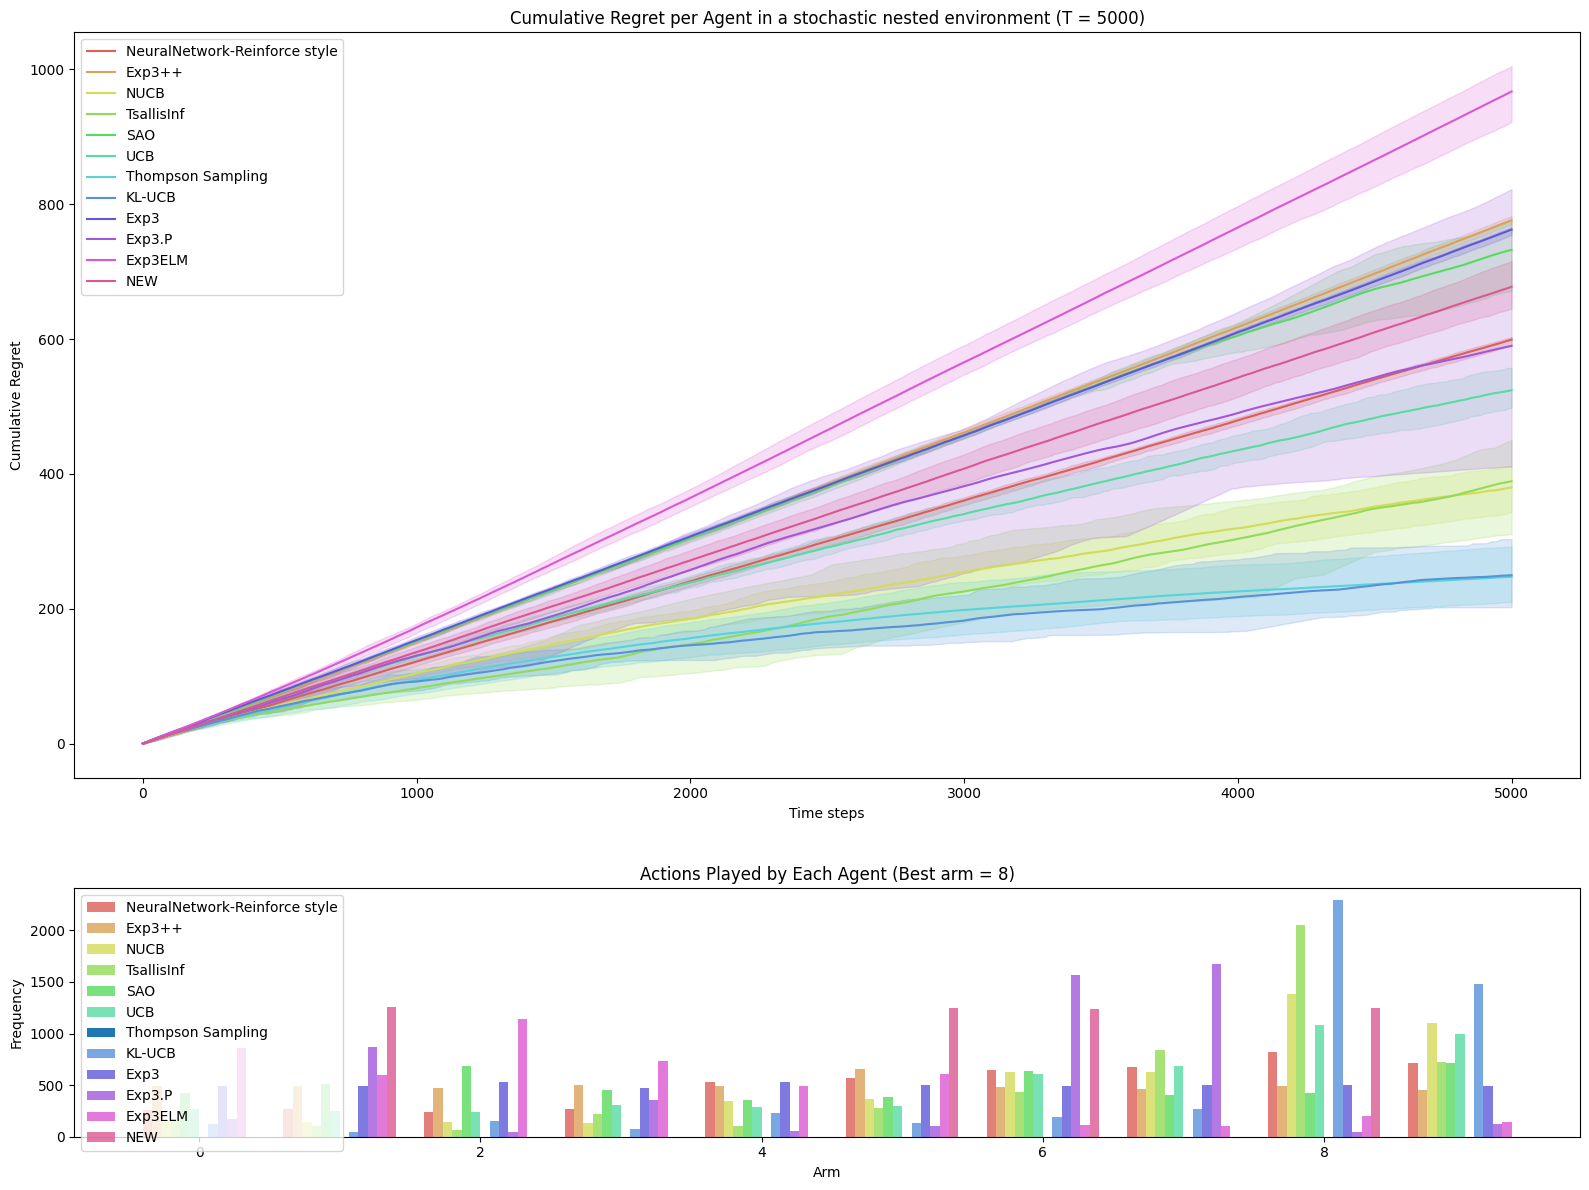

In [ ]:
plot_regret_and_histogram(regrets, agents=[exp3pp, nucb, tsallis, sao, ucb, ts, klucb, exp3, exp3P, exp3elm, new], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)

/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/Stochastic/src/environment/tree.py:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


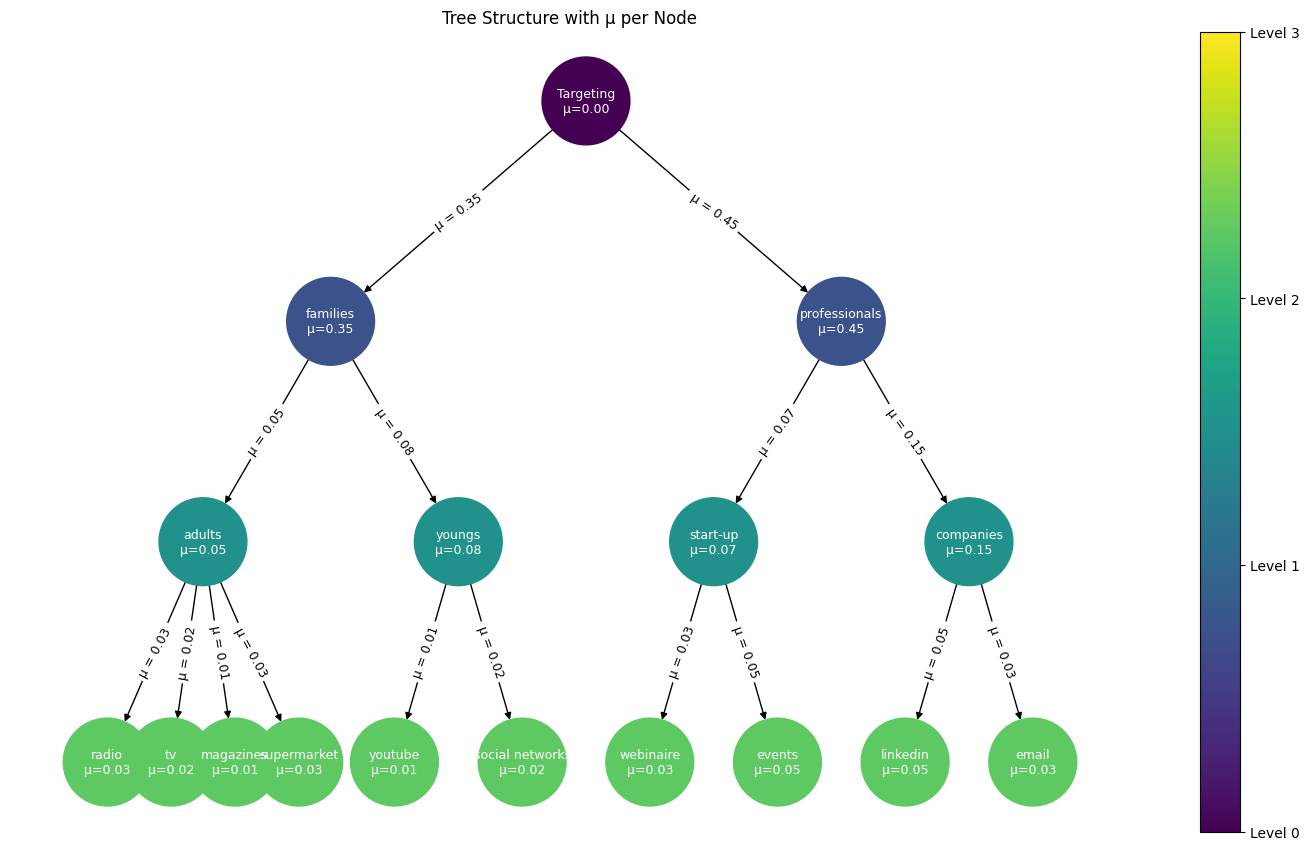

  0%|          | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [19]:
T = 5_000
K = 10

env = NestedBanditEnv()
tree = env.tree
nklucb = NKLUCB(tree, T)
klucb = KLUCB(tree, T)
ucb = UCB(tree, T)
nucb = NUCB(tree, T)
env.tree.visualize_tree_mu()


regrets = experiment(environment=env, agents=[nklucb, klucb, ucb, nucb], Nmc=10, T=T)

plot_regret_and_histogram(regrets, agents=[nklucb, ucb, klucb, nucb], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_15685/2956263913.py:48: RuntimeWarning: divide by zero encountered in power
  return (np.sum( (self.eta_t * (self.L_hat - x)) ** self.inverse_exponent ) - 1) ** 2
/Users/a.cablant/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_optimize.py:2988: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
 10%|█         | 1/10 [00:01<00:10,  1.14s/it]

Exp3.P begin at time t= 3455
Exp3.P begin at time t= 3750


 20%|██        | 2/10 [00:02<00:09,  1.15s/it]

Exp3.P begin at time t= 3255


 40%|████      | 4/10 [00:04<00:06,  1.14s/it]

Exp3.P begin at time t= 3568
Exp3.P begin at time t= 3467


 50%|█████     | 5/10 [00:05<00:05,  1.14s/it]

Exp3.P begin at time t= 3196


 70%|███████   | 7/10 [00:07<00:03,  1.13s/it]

Exp3.P begin at time t= 3472
Exp3.P begin at time t= 3549


 80%|████████  | 8/10 [00:09<00:02,  1.13s/it]

Exp3.P begin at time t= 3711


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Exp3.P begin at time t= 3340


100%|██████████| 10/10 [01:45<00:00, 10.52s/it]


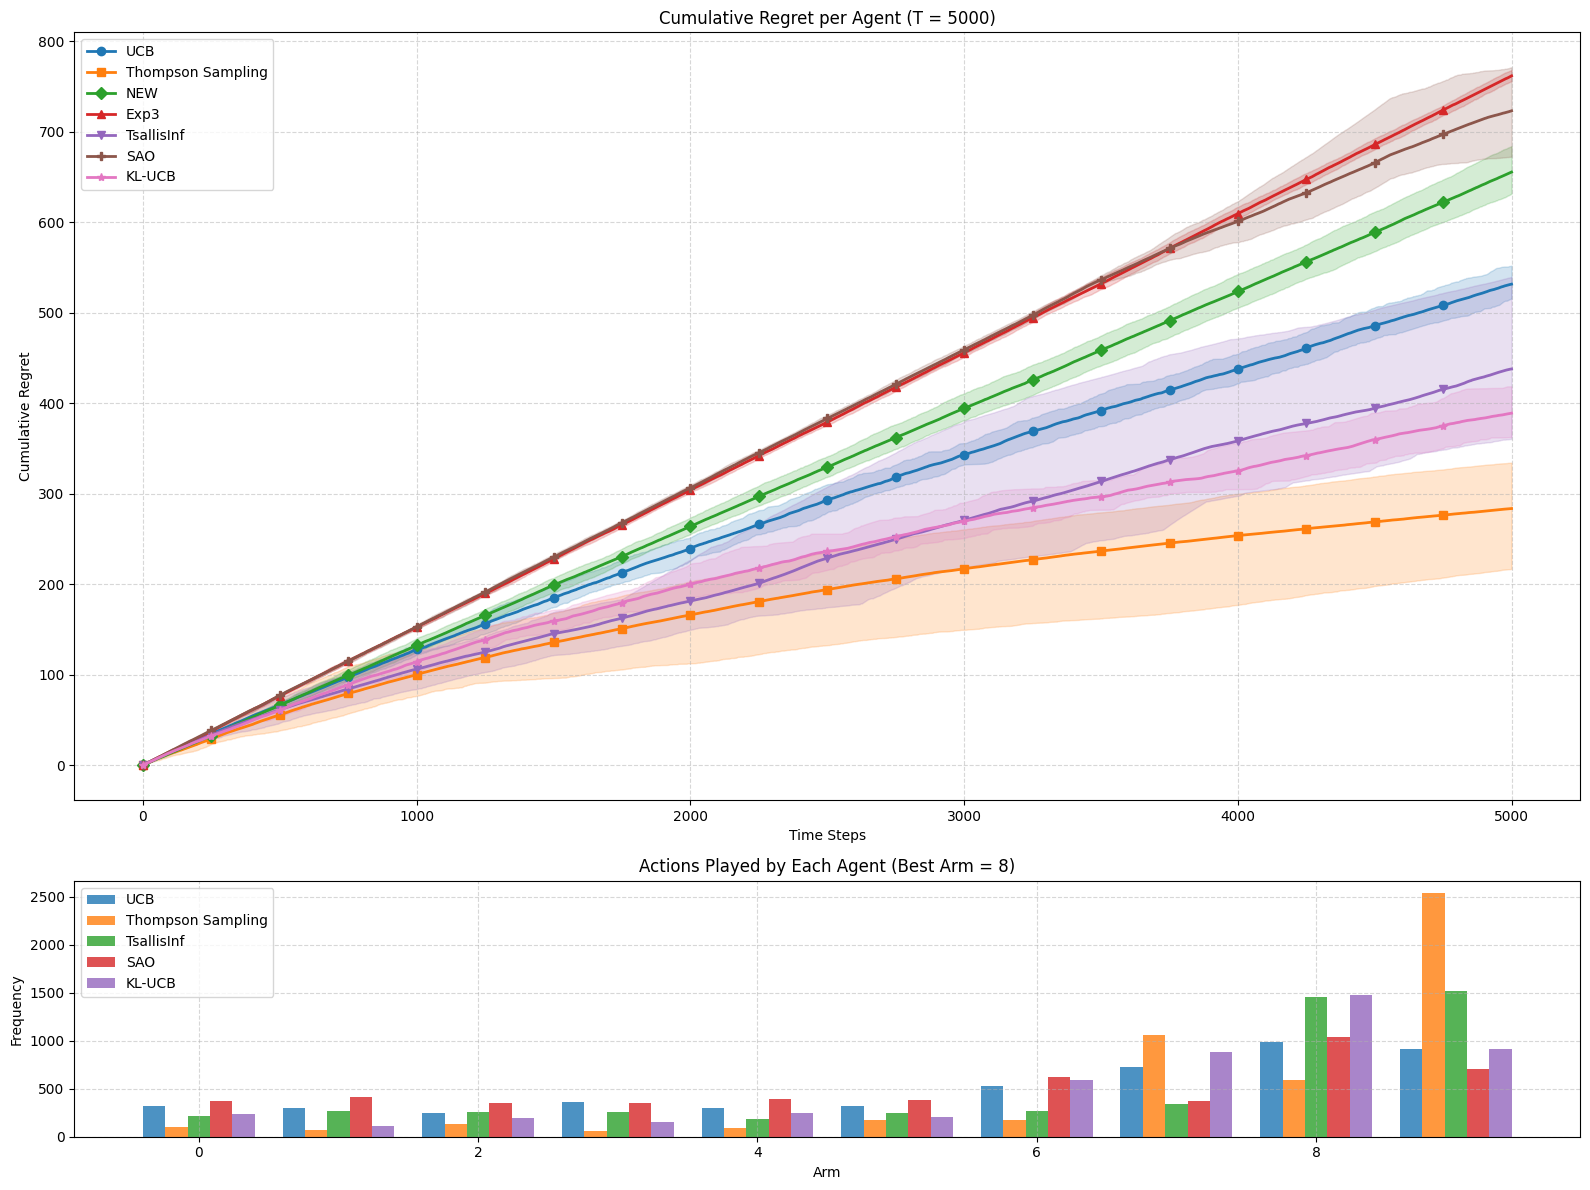

In [21]:
T = 5_000
K = 10
env = NestedBanditEnv()
tree = env.tree

tsallis = TsallisInf(tree, T)
klucb = KLUCB(tree, T)
ucb = UCB(tree, T)
new = NestedExponentialWeights(tree, T)
ts = TS(tree, T)
sao = SAO(tree, T)
exp3 = Exp3(tree, T)

regrets = experiment(environment=env, agents=[ucb, ts, new, exp3, tsallis, sao, klucb], Nmc=10, T=T)
plot_regret_and_histogram(regrets, agents=[ucb, ts, tsallis, sao, klucb], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)